In [1]:
import zipfile
import pandas as pd
from anomaly_detector import AnomalyDetector
from signal_classifier import SignalClassifier
from baseline import BaselineBacktest

In [2]:
# .csv файл слишком много весит, пришлось добавить в архив
zip_path = './raw_data/combined_data.zip'
extract_to = './raw_data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [3]:
df = pd.read_csv("./raw_data/combined_data.csv", sep=";", parse_dates=["UTC"])
df = df.replace(
    {
    "8e2b0325-0292-4654-8a18-4f63ed3b0e09": "VTBR", # ВТБ
    "e6123145-9665-43e0-8413-cd61b8aa9b13": "SBER", # Сбер
    "10e17a87-3bce-4a1f-9dfc-720396f98a3c": "YNDX", # Яндекс
    "926fdfbf-4b07-47c9-8928-f49858ca33f2": "ABRD", # Абрау Дюрсо
    "f91ef690-56e6-49fa-9cd8-4e4e767189bd": "X5", # X5 Retail Group
    "fa6aae10-b8d5-48c8-bbfd-d320d925d096": "CHMF", # Северсталь
    "962e2a95-02a9-4171-abd7-aa198dbe643a": "GAZP", # Газпром
    }
    ).sort_values(by=["UID", "UTC"]).reset_index(drop=True)

df.head()

,UID,UTC,open,close,high,low,volume
0,ABRD,2023-01-03 07:00:00+00:00,191.0,191.0,191.0,190.0,81
1,ABRD,2023-01-03 07:01:00+00:00,191.0,191.0,191.0,191.0,10
2,ABRD,2023-01-03 07:02:00+00:00,191.0,191.0,191.0,191.0,12
3,ABRD,2023-01-03 07:03:00+00:00,191.5,191.5,191.5,191.5,20
4,ABRD,2023-01-03 07:04:00+00:00,191.5,191.5,191.5,191.5,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2784558 entries, 0 to 2784557
Data columns (total 7 columns):
 #   Column  Dtype              
---  ------  -----              
 0   UID     object             
 1   UTC     datetime64[ns, UTC]
 2   open    float64            
 3   close   float64            
 4   high    float64            
 5   low     float64            
 6   volume  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(1)
memory usage: 148.7+ MB


In [5]:
TICKERS = df.UID.unique().tolist()
TICKERS

['ABRD', 'CHMF', 'GAZP', 'SBER', 'VTBR', 'X5', 'YNDX']

In [6]:
custom_params = {
    "n_estimators": 500,
    "contamination": 0.1,  # 10% аномалий
    "max_samples": 0.8,
    "n_jobs": -1,
    "random_state": 123
}

anomaly_detector = AnomalyDetector(df, model_params=custom_params)
extended_df, features = anomaly_detector.generate_features()

extended_df

,UID,UTC,open,close,high,low,volume,return,amplitude
0,ABRD,2023-01-03 07:00:00+00:00,191.0,191.0,191.0,190.0,81,0.000000,0.005263
1,ABRD,2023-01-03 07:01:00+00:00,191.0,191.0,191.0,191.0,10,0.000000,0.000000
2,ABRD,2023-01-03 07:02:00+00:00,191.0,191.0,191.0,191.0,12,0.000000,0.000000
3,ABRD,2023-01-03 07:03:00+00:00,191.5,191.5,191.5,191.5,20,0.000000,0.000000
4,ABRD,2023-01-03 07:04:00+00:00,191.5,191.5,191.5,191.5,1,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2784553,YNDX,2024-06-14 20:45:00+00:00,4075.0,4075.0,4082.6,4071.4,126,0.000000,0.002751
2784554,YNDX,2024-06-14 20:46:00+00:00,4080.0,4076.0,4085.8,4071.6,388,-0.000980,0.003488
2784555,YNDX,2024-06-14 20:47:00+00:00,4076.0,4071.8,4078.0,4071.6,166,-0.001030,0.001572
2784556,YNDX,2024-06-14 20:48:00+00:00,4075.0,4071.8,4075.0,4071.8,96,-0.000785,0.000786


In [ ]:
features

['return', 'amplitude']

In [8]:
df_with_anomalies = anomaly_detector.detect_anomalies()
df_with_anomalies

,UID,UTC,open,close,high,low,volume,return,amplitude,anomaly_score,anomaly
0,ABRD,2023-01-03 07:00:00+00:00,191.0,191.0,191.0,190.0,81,0.000000,0.005263,-1,1
1,ABRD,2023-01-03 07:01:00+00:00,191.0,191.0,191.0,191.0,10,0.000000,0.000000,1,0
2,ABRD,2023-01-03 07:02:00+00:00,191.0,191.0,191.0,191.0,12,0.000000,0.000000,1,0
3,ABRD,2023-01-03 07:03:00+00:00,191.5,191.5,191.5,191.5,20,0.000000,0.000000,1,0
4,ABRD,2023-01-03 07:04:00+00:00,191.5,191.5,191.5,191.5,1,0.000000,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2784553,YNDX,2024-06-14 20:45:00+00:00,4075.0,4075.0,4082.6,4071.4,126,0.000000,0.002751,-1,1
2784554,YNDX,2024-06-14 20:46:00+00:00,4080.0,4076.0,4085.8,4071.6,388,-0.000980,0.003488,-1,1
2784555,YNDX,2024-06-14 20:47:00+00:00,4076.0,4071.8,4078.0,4071.6,166,-0.001030,0.001572,1,0
2784556,YNDX,2024-06-14 20:48:00+00:00,4075.0,4071.8,4075.0,4071.8,96,-0.000785,0.000786,1,0


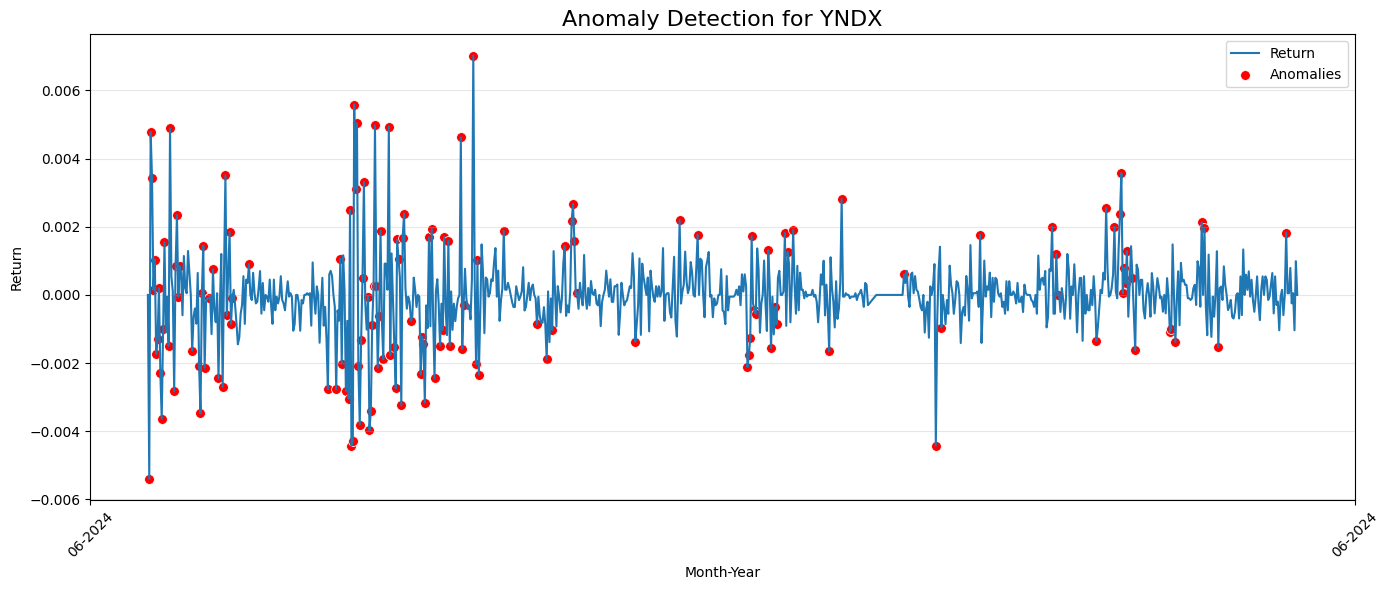

In [9]:
anomaly_detector.visualize_anomalies(instrument_id="YNDX", is_interactive=False, date_from="2024-06-01", date_to="2024-06-04")

In [10]:
gen_features = [
    "sma_3", "sma_5", "sma_7", "sma_10", 
    "ema_3", "ema_5", "ema_7", "ema_10", 
    "rsi_7", "rsi_14", "rsi_28", 
    "atr_7", "atr_14", "atr_28", 
    "volume_ratio_10", "volume_ratio_20", "volume_ratio_30", 
    "amplitude_mean_10", "amplitude_mean_20", "amplitude_mean_30", 
    "return_lag_3", "return_lag_5", "return_lag_7", "return_lag_10"
    ]

In [11]:
signal_classifier = SignalClassifier(df_with_anomalies, features=gen_features, lookahead=10)

In [12]:
signal_classifier.train(train_period_end="2024-08-31", eval_period_end="2024-09-30")

0:	learn: 0.6870493	test: 0.6887850	best: 0.6887850 (0)	total: 224ms	remaining: 1m 51s
100:	learn: 0.6211869	test: 0.6430163	best: 0.6430069 (99)	total: 7.69s	remaining: 30.4s
200:	learn: 0.6171860	test: 0.6413317	best: 0.6413317 (200)	total: 15.1s	remaining: 22.5s
300:	learn: 0.6133086	test: 0.6400948	best: 0.6400941 (299)	total: 25s	remaining: 16.5s
400:	learn: 0.6093176	test: 0.6391513	best: 0.6391428 (398)	total: 32.5s	remaining: 8.02s
499:	learn: 0.6057672	test: 0.6387511	best: 0.6387353 (497)	total: 40.5s	remaining: 0us

bestTest = 0.6387353114
bestIteration = 497

Shrink model to first 498 iterations.
Модель успешно обучена!


In [13]:
# signal_classifier.evaluate()

In [14]:
signal_classifier.feature_importance().head()

,Feature Id,Importances
0,rsi_28,15.442257
1,return,11.356730
2,rsi_7,11.263865
3,amplitude,7.618549
4,rsi_14,6.010383


In [15]:
baseline_backtester = BaselineBacktest(df)
baseline_portfolio = baseline_backtester.run_backtest(init_cash=100_000)
baseline_metrics = baseline_backtester.get_metrics(TICKERS)

baseline_metrics

{'ABRD': {'Sharpe Ratio': 0.32543451328872447,
  'Sortino Ratio': 0.467255137975541,
  'Max Drawdown': 60.58854440357331},
 'CHMF': {'Sharpe Ratio': 0.7124289084215669,
  'Sortino Ratio': 1.009155144432127,
  'Max Drawdown': 50.24875621890548},
 'GAZP': {'Sharpe Ratio': 0.37408425108012816,
  'Sortino Ratio': 0.5307747375928417,
  'Max Drawdown': 43.13630229419702},
 'SBER': {'Sharpe Ratio': 0.9310010515979383,
  'Sortino Ratio': 1.3171043178873187,
  'Max Drawdown': 33.58048603335048},
 'VTBR': {'Sharpe Ratio': 0.7920432436942507,
  'Sortino Ratio': 4163.205842376304,
  'Max Drawdown': 37.56131057484795},
 'X5': {'Sharpe Ratio': 0.20967372954107352,
  'Sortino Ratio': 0.2962082057628811,
  'Max Drawdown': 9.874987886423103},
 'YNDX': {'Sharpe Ratio': 1.0030621246747022,
  'Sortino Ratio': 1.4215888395619343,
  'Max Drawdown': 26.198439241917505}}

In [16]:
signal_portfolio = signal_classifier.run_backtest(init_cash=100_000)
signal_metrics = signal_classifier.get_metrics(TICKERS)

signal_metrics

{'ABRD': {'Sharpe Ratio': 3.563959127320114,
  'Sortino Ratio': 5.620069718788687,
  'Max Drawdown': 5.60899068408221},
 'CHMF': {'Sharpe Ratio': 10.472015841563266,
  'Sortino Ratio': 20.110614736846138,
  'Max Drawdown': 4.066905049563867},
 'GAZP': {'Sharpe Ratio': 15.934461861035079,
  'Sortino Ratio': 29.674139861587104,
  'Max Drawdown': 3.435027557705311},
 'SBER': {'Sharpe Ratio': 18.277054892201548,
  'Sortino Ratio': 39.80615838721218,
  'Max Drawdown': 1.8537743442341836},
 'VTBR': {'Sharpe Ratio': 15.49838299530149,
  'Sortino Ratio': 30.118625031646204,
  'Max Drawdown': 3.3566367965763386},
 'X5': {'Sharpe Ratio': -0.7919744892094376,
  'Sortino Ratio': -0.8399915029163684,
  'Max Drawdown': 0.03044192354156985},
 'YNDX': {'Sharpe Ratio': inf, 'Sortino Ratio': inf, 'Max Drawdown': nan}}

>__Комментарий по акциям Яндекса (тикер "YNDX"):__ Так как данные есть только до июня 2024, а тестовая выборка начинается с 01.10.2024, то модель ничего не смогла предсказать...